In [1]:
import time
from IPython.display import display, Markdown, Latex
import tensorflow as tf
import numpy as np
import scipy
import scipy.sparse as sparse
import gpflow
from gpflow import set_trainable
import matplotlib.pyplot as plt
from ggp import SVGGP
from kernel_rf import GraphKernelMultihop, InducingGraphVariables
from util import simmetrize as sim, predictMulti, accuracy, load_data_BA
from scipy.cluster.vq import kmeans2
%matplotlib inline
#stopping tensorflow depraction warning (that gets triggered by GPflow)
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

# Plotting the distributions

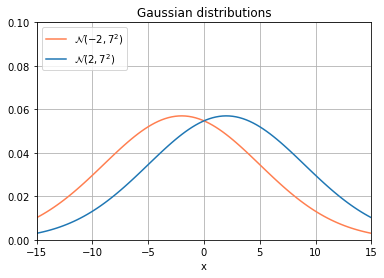

In [2]:

mean1 = -2
mean2= 2
std2= 7
std1 = 7
x_min = -15
x_max = 15
x = np.linspace(x_min, x_max, 100)

y1 = scipy.stats.norm.pdf(x,mean1,std1)
y2 = scipy.stats.norm.pdf(x,mean2,std2)
plt.plot(x,y1, color='coral',label="$\mathcal{N}(-2,7^2)$")
plt.legend(loc="upper left")
plt.plot(x,y2,label="$\mathcal{N}(2,7^2)$")
plt.legend(loc="upper left")
plt.grid()
plt.title("Gaussian distributions")
plt.xlim(x_min,x_max)
plt.ylim(0,0.1)


plt.xlabel('x')

plt.savefig("normal_distribution.png")
plt.show()

# Creating toy data and adjacency matrix

In [3]:
n = 1000
it=1000
np.random.seed(1234)
features=np.concatenate(( np.random.normal(mean1,std1,n),np.random.normal(mean2,std2,n))).reshape((2*n,1))
y=np.concatenate((np.zeros(n),np.ones(n)))

In [4]:
adj=np.zeros((2*n,2*n))
for i in range(adj.shape[0]):
    for j in range(adj.shape[0]):
        if(i!=j):
            if((i<n and j<n) or (i>=n and j>=n)):
                adj[i,j]=np.random.binomial(1,0.1)
            else:
                adj[i,j]=np.random.binomial(1,0.01)
adj_matrix=sim(adj)

In [5]:
rand= np.random.choice(2*n,1100,replace=False)

x_train=rand[:100].astype("float64")
x_test=rand[100:].astype("float64")
y_train=y[rand[:100]].astype("float64")
y_test=y[rand[100:]].astype("float64")

# Setting up the toy data experiments

In [6]:
def experimentGP(max_iter):
    
    display(Markdown('# Toy dataset GP'))
    
    #adapting data
    x_train_GP=features[x_train.astype("int64")]
    x_test_GP=features[x_test.astype("int64")]
    
    #defining the kernel
    kernel = gpflow.kernels.Matern32()
    invlink = gpflow.likelihoods.RobustMax(2)
    likelihood = gpflow.likelihoods.MultiClass(2, invlink=invlink)
    Z = InducingGraphVariables(
      kmeans2(features, len(x_train), minit='points')[0]
    )
    display(Markdown('### Kernel before training'))
    gpflow.utilities.print_summary(kernel, fmt="notebook")
    
    #defining the model
    m = gpflow.models.SVGP(
        kernel=kernel,
        likelihood=likelihood,
        inducing_variable=Z,
        num_latent_gps=2
    )
    
    #learning
    start_time = time.time()
    res = gpflow.optimizers.Scipy().minimize(
    m.training_loss_closure((x_train_GP,y_train)),
    variables=m.trainable_variables,
    method="l-bfgs-b",
    options={"disp": True, "maxiter": max_iter},
    )
    display(Markdown("#### Training iteration rate: " + f"{res.nfev / (time.time() - start_time):.3f} iter/s"))
    display(Markdown('### Kernel after training'))
    gpflow.utilities.print_summary(kernel, fmt="notebook")
    
    #testing
    predict=predictMulti(m.predict_y(x_test_GP)[0])
    test_err= accuracy(predict,y_test)
    predict=predictMulti(m.predict_y(x_train_GP)[0])
    train_err= accuracy(predict,y_train)
    display(Markdown('### Results'))
    display(Markdown(f"Train acc: {train_err * 100}%"))
    display(Markdown(f"Test acc: {test_err * 100}%"))
    
    
def plot(kernel):
    degree=kernel.nodedegree(adj_matrix)
    degree_plot=degree[degree<100]
    bins= np.arange(0, degree_plot.max() + 1.5) - 0.5
    plt.title("Toy dataset")
    plt.xlabel("Degree")
    plt.ylabel("Number of nodes")
    plt.hist(degree_plot,bins)
    plt.grid()
    plt.xticks(np.arange(1,21,1))
    plt.savefig("toydata.png")
    plt.show()
    display(Markdown(f"""| No. of Nodes    | % of Nodes with degree <= 20   | Average degree| Max degree| Label rate                            |
                         |-----------------|:-----------------------------------------:|--------------------------|----------------------|---------------------------------------|
                         |{degree.shape[0]}| {degree_plot.shape[0]/degree.shape[0]:.3f}|{np.average(degree):.3f}  |{int(np.max(degree))} | {x_train.shape[0]/degree.shape[0]:.3f}|"""))
        
def experimentGGP(max_iter,hops):
    display(Markdown('# Toy dataset '+str(hops)+"-hop GGP"))
    
    #defining the kernel
    base = gpflow.kernels.Matern32()
    kernel=GraphKernelMultihop(features,base,adj_matrix,x_train.astype("int64"),hops=hops)
    if(hops==1):
        display(Markdown('### Plot '))
        plot(kernel)
    invlink = gpflow.likelihoods.RobustMax(2)
    likelihood = gpflow.likelihoods.MultiClass(2, invlink=invlink)
    Z = InducingGraphVariables(
      kmeans2(features, len(x_train), minit='points')[0]
    )
    display(Markdown('### Kernel before training'))
    gpflow.utilities.print_summary(kernel, fmt="notebook")
    
    #defining the model
    m = SVGGP(
        kernel=kernel,
        likelihood=likelihood,
        inducing_variable=Z,
        num_latent_gps=2
    )
    #learning
    start_time = time.time()
    res = gpflow.optimizers.Scipy().minimize(
    m.training_loss_closure((x_train,y_train)),
    variables=m.trainable_variables,
    method="l-bfgs-b",
    options={"disp": True, "maxiter": max_iter},
    )
    display(Markdown("#### Training iteration rate: " + f"{res.nfev / (time.time() - start_time):.3f} iter/s"))
    display(Markdown('### Kernel after training'))
    gpflow.utilities.print_summary(kernel, fmt="notebook")
    
    #testing
    predict=predictMulti(m.predict_y(x_test)[0])
    test_err= accuracy(predict,y_test)
    predict=predictMulti(m.predict_y(x_train)[0])
    train_err= accuracy(predict,y_train)
    display(Markdown('### Results'))
    display(Markdown(f"Train acc: {train_err * 100}%"))
    display(Markdown(f"Test acc: {test_err * 100}%"))

# Experiments

In [7]:
experimentGP(max_iter=it)

# Toy dataset GP

### Kernel before training

name,class,transform,prior,trainable,shape,dtype,value
Matern32.variance,Parameter,Softplus,,True,(),float64,1
Matern32.lengthscales,Parameter,Softplus,,True,(),float64,1


#### Training iteration rate: 79.029 iter/s

### Kernel after training

name,class,transform,prior,trainable,shape,dtype,value
Matern32.variance,Parameter,Softplus,,True,(),float64,0.997334
Matern32.lengthscales,Parameter,Softplus,,True,(),float64,0.607269


### Results

Train acc: 81.0%

Test acc: 56.599999999999994%

# Toy dataset 1-hop GGP

### Plot 

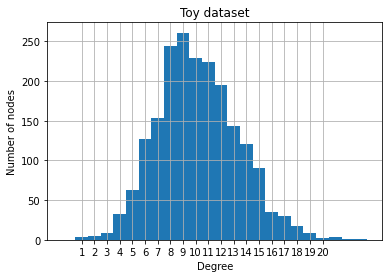

| No. of Nodes    | % of Nodes with degree <= 20   | Average degree| Max degree| Label rate                            |
                         |-----------------|:-----------------------------------------:|--------------------------|----------------------|---------------------------------------|
                         |2000| 1.000|10.169  |23 | 0.050|

### Kernel before training

name,class,transform,prior,trainable,shape,dtype,value
GraphKernelMultihop.base_kernel.variance,Parameter,Softplus,,True,(),float64,1
GraphKernelMultihop.base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,1


#### Training iteration rate: 56.277 iter/s

### Kernel after training

name,class,transform,prior,trainable,shape,dtype,value
GraphKernelMultihop.base_kernel.variance,Parameter,Softplus,,True,(),float64,1.00933
GraphKernelMultihop.base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,7.19429


### Results

Train acc: 94.0%

Test acc: 75.9%

In [8]:
experimentGGP(max_iter=it,hops=1)

In [9]:
experimentGGP(max_iter=it,hops=2)

# Toy dataset 2-hop GGP

### Kernel before training

name,class,transform,prior,trainable,shape,dtype,value
GraphKernelMultihop.base_kernel.variance,Parameter,Softplus,,True,(),float64,1
GraphKernelMultihop.base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,1


#### Training iteration rate: 4.244 iter/s

### Kernel after training

name,class,transform,prior,trainable,shape,dtype,value
GraphKernelMultihop.base_kernel.variance,Parameter,Softplus,,True,(),float64,1.00147
GraphKernelMultihop.base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,22.1604


### Results

Train acc: 100.0%

Test acc: 99.4%